# Uebung 4 Mehrklassenklassifikation mit Neuronalen Netzen


## Imports

In [64]:
import seaborn as sn

In [65]:
# 测试
import tensorflow as tf 
from tensorflow.keras.callbacks import EarlyStopping

tf.test.is_gpu_available() #旧版，返回True表示成功



True

In [66]:
import os 
import numpy as np
import tensorflow as tf
print(f"Tensor Flow Version: {tf.__version__}")
from tensorflow import keras
from tensorflow.keras import layers,models


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import wget
import pandas as pd
from skimage import io
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from skimage import io
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Tensor Flow Version: 2.3.0


## Globale Variablen
Definiere an dieser Stelle alle Variablen, die global verwendet werden, z.B.: Pfadnamen

In [67]:
# Prohibitory Class IDs 
PROHIBITORY_CLASS_IDs = [ 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]

# Mandatory Class IDs
MANDATORY_CLASS_IDs = [ 33, 34, 35, 36, 37, 38, 39, 40 ]

# Danger Class IDs
DANGER_CLASS_IDs = [ 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]

In [68]:
# TO DO: Festlegen, welche Klassen betrachtet werden

#CONSIDERED_CLASS_IDs = PROHIBITORY_CLASS_IDs
CONSIDERED_CLASS_IDs = [PROHIBITORY_CLASS_IDs[9],MANDATORY_CLASS_IDs[5]]
#CONSIDERED_CLASS_IDs = [PROHIBITORY_CLASS_IDs[9]]

print(CONSIDERED_CLASS_IDs)

[10, 38]


In [69]:
PATH_TO_GTSDB_DATA_FOLDER = r'D:\studydata\machine_bild_learn\bga2\FullIJCNN2013'
assert os.path.exists(PATH_TO_GTSDB_DATA_FOLDER), "Der angegebene Pfad existriert nicht."

In [70]:
DATA_PATH_FINAL_TRAINING_IMAGES = r'D:\studydata\machine_bild_learn\bga2\GTSRB_Final_Training_Images\GTSRB\Final_Training\Images'

# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(DATA_PATH_FINAL_TRAINING_IMAGES), "Der angegebene Pfad existriert nicht."

In [71]:
DATA_PATH_HOG_01 = r'D:\studydata\machine_bild_learn\bga2\GTSRB_Final_Training_HOG\GTSRB\Final_Training\HOG\HOG_01'

# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(DATA_PATH_HOG_01), "Der angegebene Pfad existriert nicht."

## Datenaufbereitung
Hinweise findest du hier: https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing

In [72]:
def build_train_test_datasets(CONSIDERED_CLASS_IDs, path_to_data_folder, suffix='txt'):
    '''
    Liest die Daten aus dem vorgegebenen Datenordner ein und teilt sie in train- und test-Datensaetze auf
    
    '''
    if suffix != 'txt' and suffix != 'ppm':
        print ("Abbruch der Funktion: Suffix nicht zutreffend. gueltige Suffixes sind txt oder ppm")
        return 
    
    data = []
    ppm_data = []
    data_labels = []
    subfolders_list = os.listdir(path_to_data_folder)
  
    considered_subfolders = [subfolder for subfolder in subfolders_list if int(subfolder) in CONSIDERED_CLASS_IDs]
    for subfolder in considered_subfolders:
       
        path_to_considered_datafolder = os.path.join(path_to_data_folder, subfolder)
        for filepath in os.listdir(path_to_considered_datafolder):
            # Final Training HOG Features of GTSRB-Images
            if filepath.endswith(suffix):
                full_filepath = os.path.join(path_to_data_folder, subfolder, filepath)
                assert os.path.exists(full_filepath), "Der angegebene Pfad existriert nicht."
                if suffix == 'txt':
                    text_file = open(full_filepath, "r")
                    txt_lines = text_file.read().split('\n')
                    txt_lines = [float(x) for x in txt_lines]
                    data.append(txt_lines)
                    data_labels.append(int(subfolder))
                else:
                    ppm_file = io.imread(full_filepath)
                    ppm_file_resized = resize(ppm_file, (40, 40), anti_aliasing=True)
                    data.append(ppm_file_resized)
                    data_labels.append(int(subfolder))


    data = np.array(data, dtype=np.float32)
    data_labels = np.array(data_labels)
   # pd.get_dummies(np.array(data_labels)).values    #  np.array(data_labels)


    X_train, X_val, y_tain, y_val = train_test_split(data,data_labels, test_size=0.1, random_state=42)
        
    
    return X_train, X_val, y_tain, y_val, data, data_labels

In [73]:
X_train_hog_01, X_val_hog_01, y_train_hog_01, y_val_hog_01, txt_data_hog_01, data_labels_hog_01 = build_train_test_datasets(CONSIDERED_CLASS_IDs, DATA_PATH_FINAL_TRAINING_IMAGES, suffix='ppm')

In [74]:
print(X_train_hog_01.shape)
print(y_train_hog_01.shape)
print(X_val_hog_01.shape)  
print(y_val_hog_01.shape)

(3672, 40, 40, 3)
(3672,)
(408, 40, 40, 3)
(408,)


## Aufbau des Modells
Zum Aufbau deines Modells kannst du dich an die gezeigten Beispiele richten. Implementiere zuerst ein einfaches Modell, welches du je nach Performance erweitern kannst. 

Unten findest du die Auflistung der Schichten (Layers), die du für dein Modell miteinander kombinieren kannst. 


Überlege dir, welche Layers für die Klassifikationsaufgabe mit HOG-Features gut sind und welche Layer sich für die Klassifikationsaufgabe mit ppm-Dateien eignen.

In [75]:
from tensorflow.keras import regularizers


In [76]:
model = models.Sequential([
    tf.keras.Input(shape=(40,40,3)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),    
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(43 ),
    tf.keras.layers.Activation('softmax')
    
])



keras.backend.clear_session()

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [78]:
tf.keras.utils.plot_model(model,  show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Kompilieren des Modells
Eine detaillierte Beschreibung der [compile](https://keras.io/api/models/model_training_apis/#compile-method)-Methode findest du in Keras API Referenz.

In [79]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
batch_size=8
epochs=50


# Kompiliere das Modell
model.compile(loss='sparse_categorical_crossentropy',
              #optimizer=keras.optimizers.Adam(learning_rate=0.0001),
             # optimizer='adam',
              optimizer = keras.optimizers.SGD(lr=0.003, momentum=0.9, clipnorm=1.),

             # optimizer=keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

## Training des Modells
Eine detaillierte Beschreibung der [fit](https://keras.io/api/models/model_training_apis/#fit-method)-Methode findest du in Keras API Referenz.

In [80]:

history = model.fit(X_train_hog_01,y_train_hog_01,validation_data=(X_val_hog_01, y_val_hog_01), batch_size=batch_size,epochs=epochs,callbacks=[early_stopping])
final_epoch = early_stopping.stopped_epoch - 1
print("Final training epoch:", final_epoch)
# Die Warnung kannst du ignorieren.

Epoch 1/50


459/459 [==============================] - 1s 3ms/step - loss: 1.9758 - accuracy: 0.4943 - val_loss: 1.4719 - val_accuracy: 0.5294
Epoch 2/50
459/459 [==============================] - 1s 3ms/step - loss: 1.2553 - accuracy: 0.5076 - val_loss: 1.5858 - val_accuracy: 0.5049
Epoch 3/50
459/459 [==============================] - 1s 3ms/step - loss: 1.0246 - accuracy: 0.5079 - val_loss: 1.0343 - val_accuracy: 0.4926
Epoch 4/50
459/459 [==============================] - 1s 3ms/step - loss: 0.8959 - accuracy: 0.5008 - val_loss: 1.5078 - val_accuracy: 0.4706
Epoch 5/50
459/459 [==============================] - 1s 3ms/step - loss: 0.8307 - accuracy: 0.4837 - val_loss: 0.7985 - val_accuracy: 0.4755
Epoch 6/50
459/459 [==============================] - 1s 3ms/step - loss: 0.7843 - accuracy: 0.4877 - val_loss: 0.7479 - val_accuracy: 0.5343
Epoch 7/50
459/459 [==============================] - 1s 3ms/step - loss: 0.7614 - accuracy: 0.5014 - val_loss: 1.1045 - val_accuracy: 0.5123
Epoch 8/50
459/45

In [81]:
history.history

{'loss': [1.9757611751556396,
  1.2553263902664185,
  1.02456796169281,
  0.8958967328071594,
  0.8306678533554077,
  0.7842772006988525,
  0.7613720893859863,
  0.7589049339294434,
  0.718296468257904,
  0.7136038541793823,
  0.7137129306793213],
 'accuracy': [0.4942810535430908,
  0.5076252818107605,
  0.5078976154327393,
  0.5008170008659363,
  0.48366013169288635,
  0.48774510622024536,
  0.5013616681098938,
  0.5108932256698608,
  0.5095316171646118,
  0.5111655592918396,
  0.5119825601577759],
 'val_loss': [1.471934199333191,
  1.5857808589935303,
  1.0343351364135742,
  1.507813811302185,
  0.7985129952430725,
  0.7479146122932434,
  1.1044858694076538,
  0.7971144318580627,
  0.7751826047897339,
  0.7519771456718445,
  0.856322169303894],
 'val_accuracy': [0.529411792755127,
  0.5049019455909729,
  0.49264705181121826,
  0.47058823704719543,
  0.47549018263816833,
  0.5343137383460999,
  0.5122548937797546,
  0.4803921580314636,
  0.5024510025978088,
  0.5122548937797546,
  0.4

## Evaluation des Modells
Eine detaillierte Beschreibung der [evaluate](https://keras.io/api/models/model_training_apis/#evaluate-method)-Methode findest du in Keras API Referenz.

Nach der Anwendung der *evaluate*-Methode kannst du dir zusätzlich den ausfuehrlichen Klassifikationsbericht (*classification_report()*) sowie die Konfusionsmatrix (*confusion_matrix()*) anschauen.  

Test Loss: 0.7425784468650818
Test accuracy: 0.529411792755127
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


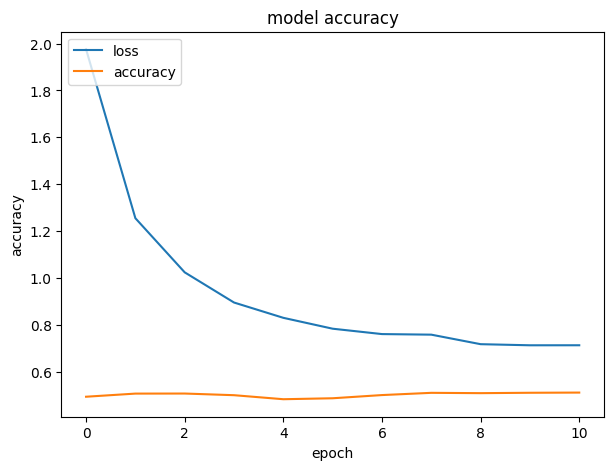

In [82]:
# Evaluiere das trainierte Modell mit den Testdaten
loss,accuracy = model.evaluate(X_val_hog_01, y_val_hog_01,verbose = 0)


print('Test Loss:', loss)
print('Test accuracy:', accuracy)
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper left')



## Speichern des trainierten Modells
Zum Speichern des trainierten Modells kann *save*-Methode
Weiterfuehrende Informationen zu dieser Methode unter folgendem [Link](https://keras.io/api/models/model_saving_apis/) zu finden. 

In [83]:
# Speichere das trainierte Modell, um dessen Wiederverwendung zu ermoeglichen
FILEPATH = r'D:\studydata\machine bild learn\bga2\model'
model.save(FILEPATH)

INFO:tensorflow:Assets written to: D:\studydata\machine bild learn\bga2\model\assets


## Nutzen des trainierten Modells zum Vorhersagen von Verkehrszeichen-Klassen 
Zum Wiederverwenden des trainierten gespeicherten Modells kann die [load_model](https://keras.io/api/models/model_saving_apis/#loadmodel-function)-Funktionverwendet werden.

Eine detaillierte Beschreibung der [predict](https://keras.io/api/models/model_training_apis/#predict-method)-Methode findest du in Keras API Referenz.

(408, 43)
(408,)
(408,)


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

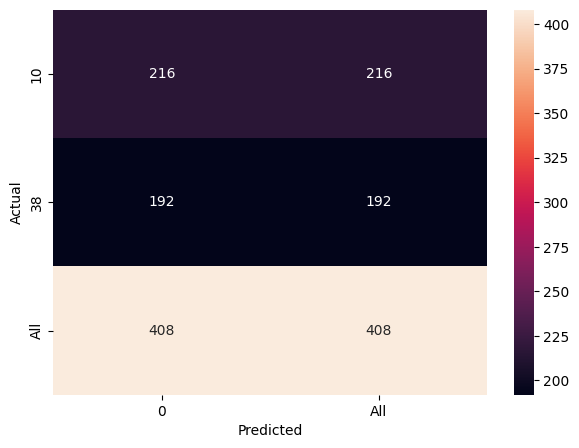

In [84]:
# Lade das trainierte Modell und teste die Erkennung der Verkehrszeichen-Klassen mit eigenen Beispielen
y_pred = model.predict(X_val_hog_01)
print(y_pred.shape)
predicted = np.argmax(y_pred, axis=1)
print(predicted.shape)
actual=y_val_hog_01
print(actual.shape)

plt.rcParams['figure.figsize'] = [7,5]
confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'],margins = True)
sn.heatmap(confusion_matrix, annot=True, fmt='g')